In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import h5py
from scipy.interpolate import interp1d
from helita.sim import multi3d
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter


In [5]:
sim_name = 'cb24bih'
sim_num = 's425_half'
net_name = 'cb24bih_ColMass_3x3_single_50e_128b_2a_ComboData'

M3D_SIM = f'path/name'

NN_INT = f'path/{net_name}/{sim_name}_{sim_num}.hdf5'

M3D_INT = f'path/multi3d/{sim_name}_{sim_num}.hdf5'

POP_PATH = f'path/{net_name}/{sim_name}_{sim_num}.hdf5'

FILE_WAVES = "path/wavelengths_Halpha.hdf5"


os.chdir(M3D_SIM)
sim = multi3d.Multi3dOut(directory='.')
sim.readall()
sim.set_transition(3,2)

with h5py.File(FILE_WAVES, 'r') as f:
    wave_vec = f["wavelength"][:]

with h5py.File(NN_INT, 'r') as f:
    nn_int = f["intensity"][:]
    
with h5py.File(M3D_INT, 'r') as f:
    m3d_int = f["intensity"][:]
    
with h5py.File(POP_PATH, 'r') as f:
    hpops = f["populations"][:]
    z_interp = f["populations"].attrs["z"]
    cmass_mean = f["populations"].attrs["cmass_mean"]
    cmass_scale = f["populations"].attrs["cmass_scale"]
    
c = 2.997e8 # m/s

reading ./multi3d.input
reading ./out_par
reading ./out_nu
reading ./out_pop
reading ./out_atm
transition parameters are set to:
 i   = 2
 j   = 1
 kr  = 4
 ff  = -1
 ang = 0


In [4]:
# pick out wavelengths to look at and switch units to km s-1
v = (wave_vec - wave_vec[50])/wave_vec[50]*(c*1e9)*1e-12 # km/s
np.where(np.abs(v) > 10)
print(v[30])
print(v[50])
print(wave_vec[30])
print(wave_vec[50])

15.940466550479485
0.0
656.51218098591
656.4772642229087


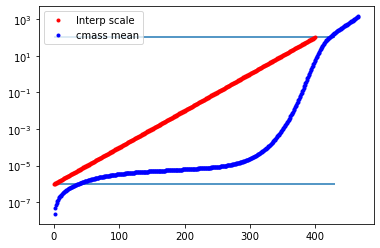

In [5]:
#visualize difference between cmass mean and scale for sim
plt.plot(cmass_scale,'r.', label='Interp scale')
plt.plot(cmass_mean, 'b.',label='cmass mean')
plt.yscale('log')
plt.hlines(cmass_scale[0],0,430)
plt.hlines(cmass_scale[-1],0,430)
plt.legend()

In [6]:
#find z's where sim is all positive after interpolating back
#need to see if we need to trim the sim before calculating intensity, 
#negative populations from reinterpolation give Nan's in intensity calc
f = interp1d(cmass_scale, hpops, kind='linear', axis = 2, fill_value = 'extrapolate')
n = f(cmass_mean)
l = np.where(n<0)[2]
b = np.bincount(l)
np.where(b==0)

(array([ 31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
         44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
         83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
         96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
        109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
        122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
        135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
        148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
        161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
        174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
        187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
        200, 201, 202, 203, 204, 205, 206, 207, 208

In [3]:
sns.set_style('dark', {'axes.grid':False, 'font.family':['sans-serif'], 'font.sans-serif':['Roman'],
                      'xtick.bottom':True, 'ytick.left':True, 'axes.edgecolor': 'black'})

656.51218098591
656.4772642229087


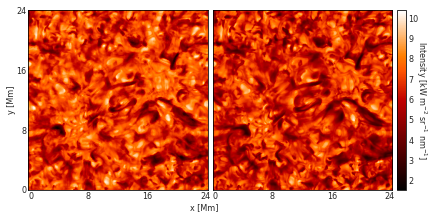

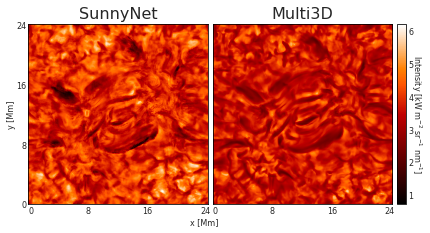

In [6]:
points = [30,50]
save_fig = True
color = cm.gist_heat
font = 8
title_font = 16

for wv in points:
    a = str(wave_vec[wv]).split('.')[0]
    b = str(wave_vec[wv]).split('.')[1][:3]
    
    path = f'path/{net_name}/{sim_name}_{sim_num}/{a}_{b}nm_FINAL.pdf'
    print(wave_vec[wv])
    
    if save_fig:
        folder1 = f'path/{net_name}'
        try:
            assert os.path.exists(folder1) == True
        except AssertionError:
            print(f'Making dir {folder1}')
            os.mkdir(folder1)
            pass
        folder2 = f'path/{net_name}/{sim_name}_{sim_num}'
        try:
            assert os.path.exists(folder2) == True
        except AssertionError:
            print(f'Making dir {folder2}')
            os.mkdir(folder2)
            pass
        
    max_v = np.nanmax(nn_int[..., wv])
    min_v = np.nanmin(nn_int[..., wv])
    if min_v < 0:
        min_v = 0
        
    fig = plt.figure(figsize=(6.6,3.3))
    gs = fig.add_gridspec(1,2, wspace=0)
    ax = gs.subplots(sharey='row')
    im = ax[0].imshow(nn_int[..., wv], vmin = min_v, vmax = max_v, aspect = 'equal', cmap = color, origin='lower')
    im = ax[1].imshow(m3d_int[..., wv], vmin = min_v, vmax = max_v, aspect = 'equal', cmap = color, origin='lower')
    
    ax[0].set_yticks([0,83,167,251])
    ax[0].set_yticklabels([0,8,16,24])
    ax[0].set_xticks([3,83,167,248])
    ax[0].set_xticklabels([0,8,16,24])
    ax[0].set_ylabel('y [Mm]', size = font)
    ax[0].yaxis.labelpad = 0

    ax[1].set_xticks([3,83,167,248])
    ax[1].set_xticklabels([0,8,16,24])                      

    if wv == 50:
        ax[0].set_title('SunnyNet', size=title_font)
        ax[1].set_title('Multi3D', size=title_font)
    
    ax[0].tick_params(pad=2, labelsize=font, length = 0)
    ax[1].tick_params(pad=2, labelsize=font, length = 0)

    fig.text(0.5, 0.04, r'x [Mm]', ha='center', fontsize=font)

    cbar_ax = fig.add_axes([ax[1].get_position().x1+0.01,ax[1].get_position().y0,0.02,ax[1].get_position().height])
    cbar_ax.tick_params(pad=2, labelsize=font, length = 0)
    cbar = fig.colorbar(im, cax=cbar_ax)
    #cbar = fig.colorbar(im,fraction=0.046, pad=0.02)
    cbar.ax.get_yaxis().labelpad = 10
    cbar.set_label(r"Intensity [kW m$^{-2}$ sr$^{-1}$ nm$^{-1}$]", rotation = 270, size = font)

    if save_fig:
        plt.savefig(path,bbox_inches='tight')

In [63]:
# COMPARE LEVEL POPULATIONS
# COMPARE LEVEL POPULATIONS

f = interp1d(cmass_mean, sim.atom.n * 1e6, kind='linear', axis = 2, fill_value = 'extrapolate')
m3d_non_lte = f(cmass_scale)

f = interp1d(cmass_mean, sim.atom.nstar * 1e6, kind='linear', axis = 2, fill_value = 'extrapolate')
m3d_lte = f(cmass_scale)

z = cmass_scale

h = np.log10(hpops)
m = np.log10(m3d_non_lte)


diff = np.abs((h-m)/m)
diff_z = diff.mean(axis=(0,1))

In [68]:
sns.set_style('dark', {'axes.grid':True, 'font.family':['sans-serif'], 'font.sans-serif':['Roman'],
                      'xtick.bottom':True, 'ytick.left':True,'axes.edgecolor': 'black',})

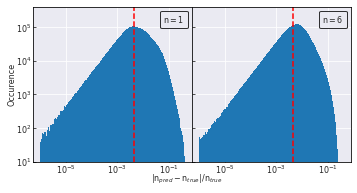

In [70]:
## Error Histogram 1,ion
save = True
path = f'path/{net_name}/{sim_name}_{sim_num}/histogram_1ion.pdf'
#bin_vec_01 = np.linspace(0,0.4,1000)
bin_vec_01 = np.logspace(-6,-.4,1000)
font = 8

fig = plt.figure(figsize=(5.7,2.85))
gs = fig.add_gridspec(1,2, wspace=0)
ax = gs.subplots(sharey='row')

ax[0].hist(diff[...,0].flatten(),bins = bin_vec_01,lw=0, label = 'n$=1$')
ax[0].axvline(np.median(diff[...,0].flatten()),c='red', ls='--')
ax[1].hist(diff[...,-1].flatten(),bins = bin_vec_01,lw=0, label = 'n$=6$')
ax[1].axvline(np.median(diff[...,0].flatten()),c='red', ls='--')

plt.setp(ax, yscale='log')

ax[0].yaxis.labelpad = 0
ax[0].minorticks_off()
ax[0].tick_params(pad=1, labelsize=font, length = 3, direction='in')


ax[0].set_ylabel('Occurence', size = font)
leg = ax[0].legend(handlelength=0, handletextpad=0,fontsize=font)
leg.legendHandles[0].set_visible(False)
leg.get_frame().set_edgecolor('black')
ax[0].set_xscale('log')


ax[0].set_ylim(1e1,4*1e5)

ax[1].set_xscale('log')
ax[1].set_ylim(1e1,4*1e5)
ax[1].minorticks_off()
ax[1].tick_params(pad=1, labelsize=font, length = 3, direction='in')
leg = ax[1].legend(handlelength=0, handletextpad=0,fontsize=font)
leg.legendHandles[0].set_visible(False)
leg.get_frame().set_edgecolor('black')

fig.text(0.5, 0.03, r'|n$_{pred}-$n$_{true}$|/n$_{true}$', ha='center', fontsize=font)

if save:
    plt.savefig(path, bbox_inches='tight')
    


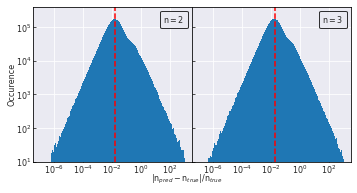

In [72]:
## Error Histogram 1,ion
save = True
path = f'path/{net_name}/{sim_name}_{sim_num}/histogram_23.pdf'
#bin_vec_23 = np.linspace(0,10,1000)
bin_vec_23 = np.logspace(-7,3,1000)
font = 8

fig = plt.figure(figsize=(5.7,2.85))
gs = fig.add_gridspec(1,2, wspace=0)
ax = gs.subplots(sharey='row')

hist,bins,_ = ax[0].hist(diff[...,2].flatten(),bins = bin_vec_23,lw=0, label = 'n$=2$')
ax[0].axvline(np.median(diff[...,2].flatten()),c='red', ls='--')

ax[1].hist(diff[...,3].flatten(),bins = bin_vec_23,lw=0, label = 'n$=3$')
ax[1].axvline(np.median(diff[...,3].flatten()),c='red', ls='--')


plt.setp(ax, yscale='log')
#ax[0].set_xlim(-.5,10.5)
ax[0].yaxis.labelpad = 0
ax[0].minorticks_off()
ax[0].tick_params(pad=1, labelsize=font, length = 3, direction='in')
ax[0].set_ylabel('Occurence', size = font)
leg = ax[0].legend(handlelength=0, handletextpad=0,fontsize=font)
leg.legendHandles[0].set_visible(False)
leg.get_frame().set_edgecolor('black')
ax[0].set_xscale('log')
ax[0].set_ylim(1e1,4*1e5)



ax[1].set_ylim(1e1,4*1e5)
ax[1].set_xscale('log')
ax[1].minorticks_off()
ax[1].tick_params(pad=1, labelsize=font, length = 3, direction='in')
leg = ax[1].legend(handlelength=0, handletextpad=0,fontsize=font)
leg.legendHandles[0].set_visible(False)
leg.get_frame().set_edgecolor('black')

fig.text(0.5, 0.03, r'|n$_{pred}-$n$_{true}$|/n$_{true}$', ha='center', fontsize=font)

if save:
    plt.savefig(path, bbox_inches='tight')

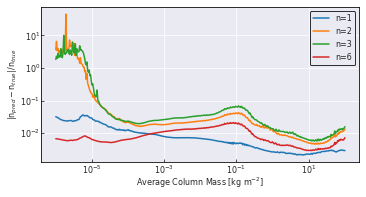

In [76]:
save = True
path = f'path/{net_name}/{sim_name}_{sim_num}/diff_z.pdf'
font = 8

fig, ax = plt.subplots(figsize=(5.7,2.85))
ax.plot(z,diff_z[:,0],label='n=1')
ax.plot(z,diff_z[:,1],label='n=2')
ax.plot(z,diff_z[:,2],label='n=3')
ax.plot(z,diff_z[:,-1],label='n=6')
ax.set_xscale('log')
ax.set_yscale('log')
leg = ax.legend(fontsize=font)
leg.get_frame().set_edgecolor('black')

ax.set_xlabel(r'Average Column Mass [kg m$^{-2}$]', size = font)
ax.set_ylabel(r'|n$_{pred}-$n$_{true}$|/n$_{true}$', size = font)
ax.tick_params(pad=1, labelsize=font, length = 3, direction='in')
ax.xaxis.labelpad = 0
ax.yaxis.labelpad = 0
ax.minorticks_off()
if save:
    plt.savefig(path, bbox_inches='tight')

In [11]:
nn_avg = np.nanmean(nn_int, axis=(0,1))
m3d_avg = np.nanmean(m3d_int, axis=(0,1))

profile_diff = (nn_avg-m3d_avg)/m3d_avg


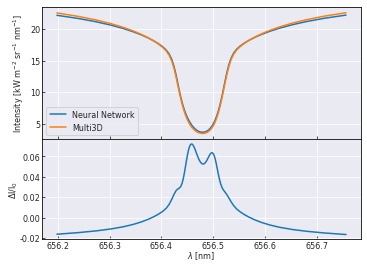

In [12]:
# Average Intensity
save = True
path = f'path/{net_name}/{sim_name}_{sim_num}/average_intensity.pdf'
font = 8
fig = plt.figure(figsize=(5.7,4.275))
gs = fig.add_gridspec(2,1, height_ratios=[1,.75], hspace=0)
(ax0,ax1) = gs.subplots()
ax0.plot(wave_vec[10:-10], nn_avg[10:-10], label = 'Neural Network')
ax0.plot(wave_vec[10:-10], m3d_avg[10:-10], label = 'Multi3D')
ax0.tick_params(pad=2, labelsize=font, length = 3, direction='in')

ax0.set_ylabel(r'Intensity [kW m$^{-2}$ sr$^{-1}$ nm$^{-1}]$', size = font)
leg = ax0.legend(fontsize=font)

ax1.plot(wave_vec[10:-10], profile_diff[10:-10])
ax1.tick_params(pad=2, labelsize=font, length = 3, direction='in')
ax1.set_ylabel(r'$\Delta$I/I$_{0}$', size = font)
ax1.set_xlabel(r'$\lambda$ [nm]', size = font)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax1.xaxis.labelpad = 0
ax1.yaxis.labelpad = 0


if save:
    plt.savefig(path, bbox_inches='tight')

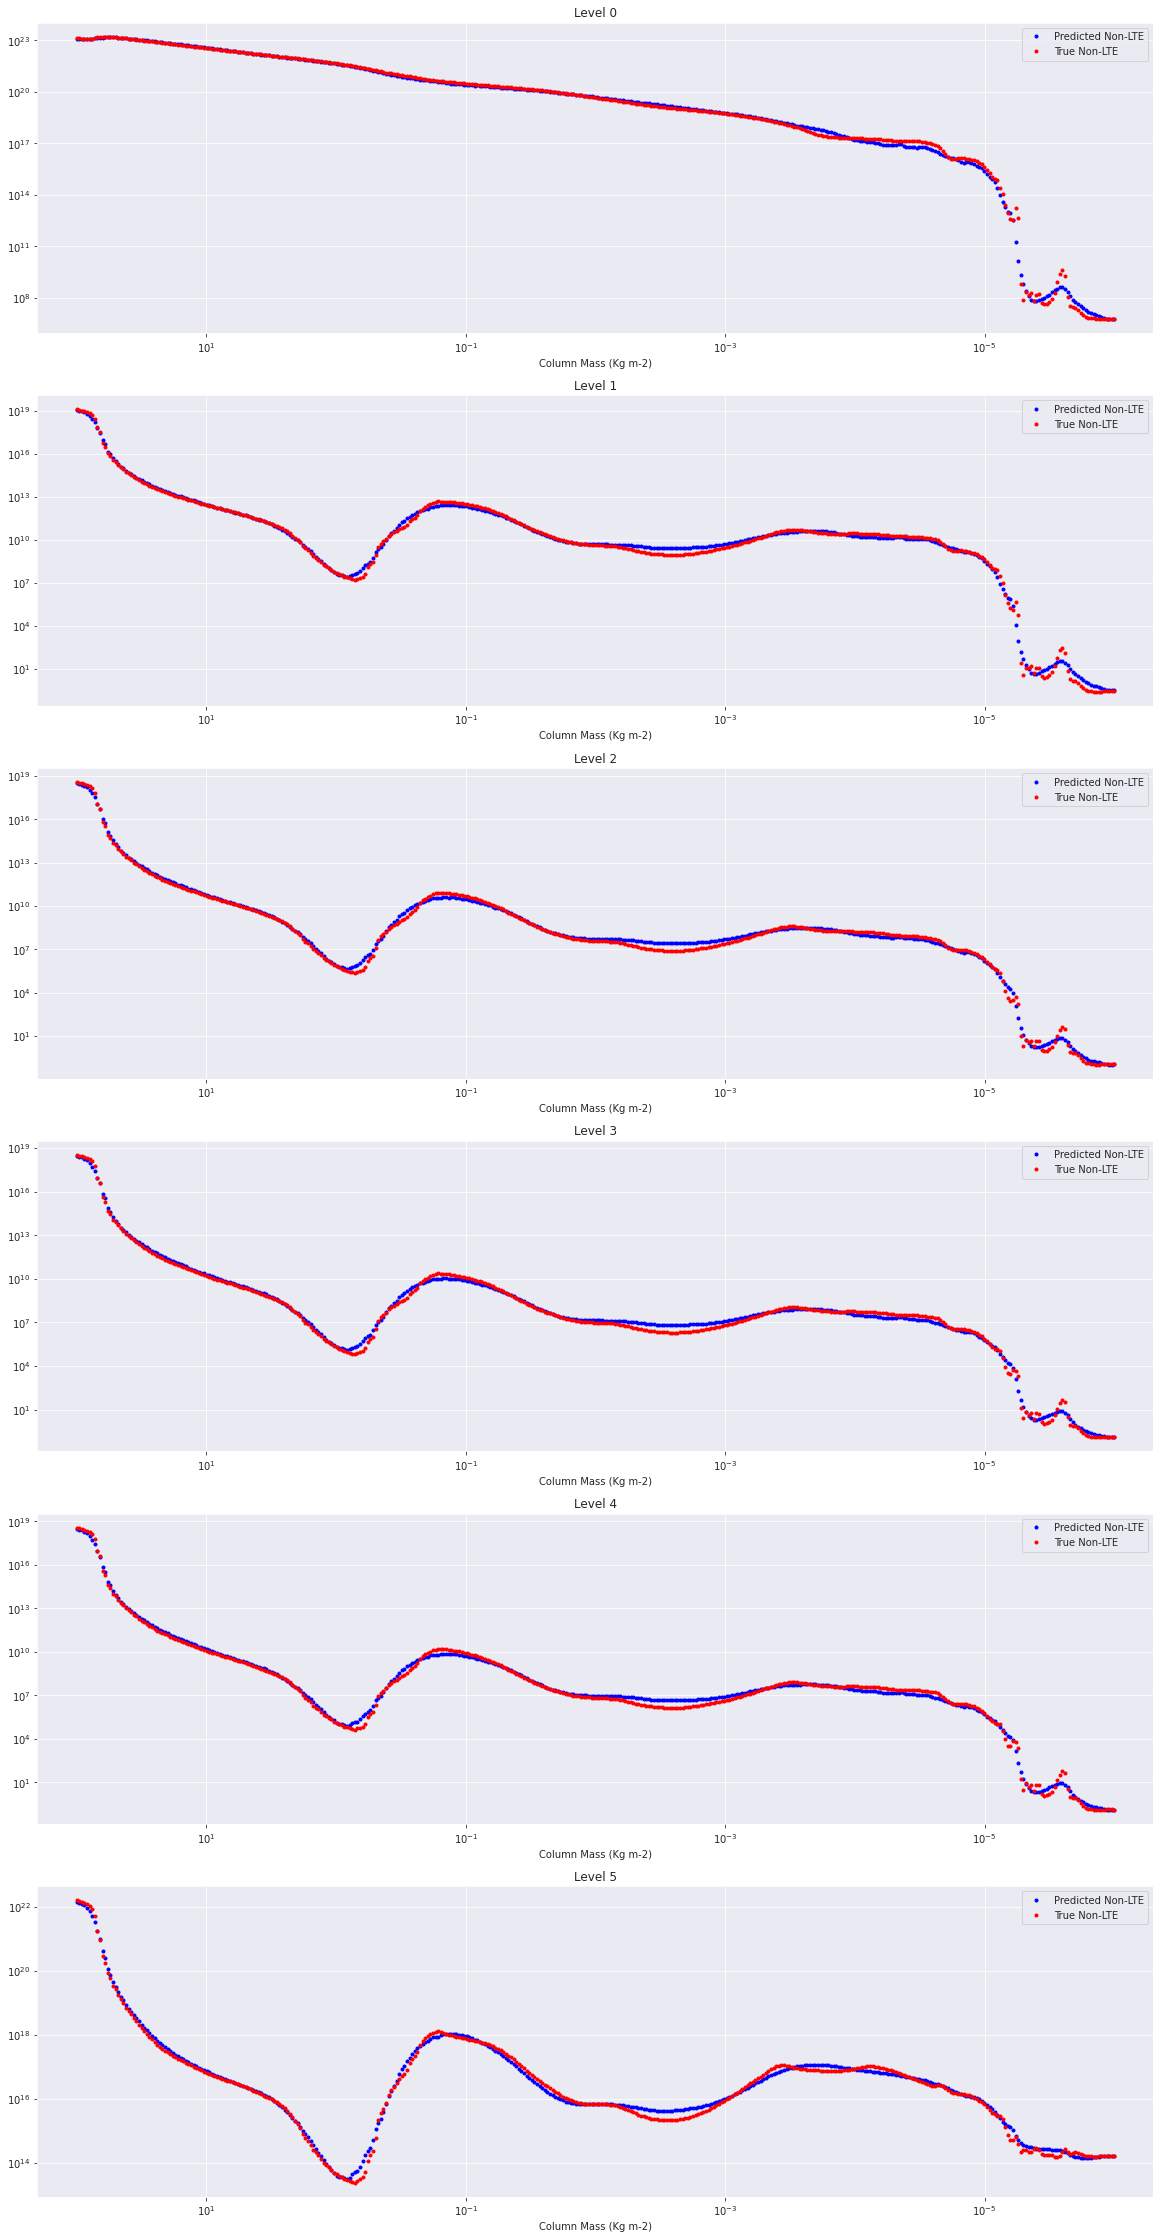

In [6]:
########### PLOT PARAMS ##########
#                                #
#                                #
#                                #
x = 0
y = 20
#                                #
#                                #
#                                #
##################################


fig, axs = plt.subplots(6, figsize=(20,40))
for i in range(0,6):
    axs[i].set_title(f"Level {i}")
    #axs[i].plot(z, np.log10(hpops[x,y,:,i]), 'b.', label = 'Predicted Non-LTE')
    #axs[i].plot(z, np.log10(m3d_non_lte[x,y,:,i]), 'r--', label = 'True Non-LTE')
    #axs[i].plot(z, np.log10(m3d_lte[x,y,:,i]), 'k--', label = 'True LTE')
    
    axs[i].plot(z, hpops[x,y,:,i], 'b.', label = 'Predicted Non-LTE')
    axs[i].plot(z, m3d_non_lte[x,y,:,i], 'r.', label = 'True Non-LTE')
    #axs[i].plot(z, m3d_lte[x,y,:,i], 'k--', label = 'True LTE')
    
    
    axs[i].set_xscale('log')
    axs[i].set_xlim(2*z[-1],.5*z[0])
    #axs[i].set_ylim(z[-1], z[0])
    axs[i].set_xlabel('Column Mass (Kg m-2)')
    #axs[i,0].set_ylabel('Log Populations')
    axs[i].set_yscale('log')
    #axs[i].set_ylim(0,25)
    axs[i].legend()